In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from data_processing import *
from globals import DATA
import math
import numpy as np
#import transformer_timeseries  as tst
import torch.nn as nn
from transformer_utils import *
import transformer_dataset as ds
import transformer_timeseries as tst



In [2]:
get_and_save_data(dir_path=DATA)

X_train, X_test, y_train, y_test = load_train_test_data(DATA)
ppg_train_conv = convert_to_2d(X_train, 0)
ecg_train_conv = convert_to_2d(X_train, 1)
abp_train_conv = convert_to_2d(y_train)
ppg_test_conv = convert_to_2d(X_test, 0)
ecg_test_conv = convert_to_2d(X_test, 1)
abp_test_conv = convert_to_2d(y_test)

ppg_train_conv_scaled = (ppg_train_conv - ppg_train_conv.min())/(ppg_train_conv.max()-ppg_train_conv.min())
ecg_train_conv_scaled = (ecg_train_conv - ecg_train_conv.min())/(ecg_train_conv.max()-ecg_train_conv.min())
abp_train_conv_scaled = (abp_train_conv - abp_train_conv.min())/(abp_train_conv.max()-abp_train_conv.min())
ppg_test_conv_scaled = (ppg_test_conv - ppg_test_conv.min())/(ppg_test_conv.max()-ppg_test_conv.min())
ecg_test_conv_scaled = (ecg_test_conv - ecg_test_conv.min())/(ecg_test_conv.max()-ecg_test_conv.min())
abp_test_conv_scaled = (abp_test_conv - abp_test_conv.min())/(abp_test_conv.max()-abp_test_conv.min())

In [3]:
ppg_train_conv.shape

(147000,)

In [4]:
# plt.figure(figsize=(28,40))
# plt.subplot(10,1,1)
# plt.plot(ppg_train_conv_scaled[89500:90500])
# plt.subplot(10,1,2)
# plt.plot(ppg_train_conv_scaled[90500:91500])
# plt.subplot(10,1,3)
# plt.plot(ppg_train_conv_scaled[91500:92500])
# plt.subplot(10,1,4)
# plt.plot(ppg_train_conv_scaled[92500:93500])
# plt.subplot(10,1,5)
# plt.plot(ppg_train_conv_scaled[93500:94500])
# plt.subplot(10,1,6)
# plt.plot(ppg_train_conv_scaled[94500:95500])
# plt.subplot(10,1,7)
# plt.plot(ppg_train_conv_scaled[95500:96500])
# plt.subplot(10,1,8)
# plt.plot(ppg_train_conv_scaled[96500:97500])
# plt.subplot(10,1,9)
# plt.plot(ppg_train_conv_scaled[97500:98500])
# plt.subplot(10,1,10)
# plt.plot(ppg_train_conv_scaled[98500:99500])


In [5]:
dim_val = 512
n_heads = 8
n_decoder_layers = 4
n_encoder_layers = 4
dec_seq_len = 92 # length of input given to decoder
enc_seq_len = 160 # length of input given to encoder
output_sequence_length = 5 # target sequence length. If hourly data and length = 48, you predict 2 days ahead
window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences
step_size = 1 # Step size, i.e. how many time steps does the moving window move at each step
in_features_encoder_linear_layer = 2048
in_features_decoder_linear_layer = 2048
max_seq_len = enc_seq_len
batch_size = 128
#batch_first = True

In [6]:
training_indices = get_indices_entire_sequence(
    data=ppg_train_conv_scaled,
    window_size=window_size,
    step_size=step_size)

training_data = ds.TransformerDataset(
    data=torch.tensor(ppg_train_conv_scaled).unsqueeze(-1).float(),
    indices=training_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length
    )

training_data = DataLoader(training_data, batch_size)

i, batch = next(enumerate(training_data))

src, trg, trg_y = batch

shape_before = src.shape
src = src.permute(1, 0, 2)
print("src shape changed from {} to {}".format(shape_before, src.shape))

shape_before = trg.shape
trg = trg.permute(1, 0, 2)
print("src shape changed from {} to {}".format(shape_before, src.shape))

From get_src_trg: data size = torch.Size([147000, 1])
src shape changed from torch.Size([128, 160, 1]) to torch.Size([160, 128, 1])
src shape changed from torch.Size([128, 5, 1]) to torch.Size([160, 128, 1])


In [7]:
src.shape

torch.Size([160, 128, 1])

In [8]:
model = tst.TimeSeriesTransformer(
    input_size=1,
    dec_seq_len=enc_seq_len,
    num_predicted_features=1,
    batch_first=False,
    )

src_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=enc_seq_len
    )

tgt_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=output_sequence_length
    )

In [9]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
src = src.to(device)
trg = trg.to(device)
trg_y = trg_y.to(device)
src_mask = src_mask.to(device)
tgt_mask = tgt_mask.to(device)


In [11]:
#train the model
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 1
for epoch in range(epochs):
    for i, batch in enumerate(training_data):
        src, trg, trg_y = batch
        src = src.permute(1, 0, 2)
        trg = trg.permute(1, 0, 2)
        trg_y = trg_y.unsqueeze(-1).permute(1, 0, 2)
        src = src.to(device)
        trg = trg.to(device)
        trg_y = trg_y.to(device)
        optimizer.zero_grad()
        output = model(
            src=src,
            tgt=trg,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            )
        loss = criterion(output, trg_y)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(i,f"Epoch: {epoch}, Loss: {loss.item()}")

0 Epoch: 0, Loss: 0.028153592720627785
10 Epoch: 0, Loss: 0.29306885600090027
20 Epoch: 0, Loss: 0.03114030696451664
30 Epoch: 0, Loss: 0.02982744388282299
40 Epoch: 0, Loss: 0.03680424764752388
50 Epoch: 0, Loss: 0.03716028854250908
60 Epoch: 0, Loss: 0.025241201743483543
70 Epoch: 0, Loss: 0.03086479939520359
80 Epoch: 0, Loss: 0.026082342490553856
90 Epoch: 0, Loss: 0.027622640132904053
100 Epoch: 0, Loss: 0.025463609024882317
110 Epoch: 0, Loss: 0.025433266535401344
120 Epoch: 0, Loss: 0.024320248514413834
130 Epoch: 0, Loss: 0.02685721218585968
140 Epoch: 0, Loss: 0.025722352787852287
150 Epoch: 0, Loss: 0.02548319101333618
160 Epoch: 0, Loss: 0.021778849884867668


KeyboardInterrupt: 

In [12]:
for i, batch in enumerate(training_data):
    if i == 300:
        src, trg, trg_y = batch
        src = src.permute(1, 0, 2)
        trg = trg.permute(1, 0, 2)
        trg_y = trg_y.unsqueeze(-1).permute(1, 0, 2)

        src = src.to(device)
        trg = trg.to(device)

        output = model(
            src=src,
            tgt=trg,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            )
        #output_list.append(output.detach().cpu().numpy())
        break

In [13]:
output.shape

torch.Size([5, 128, 1])

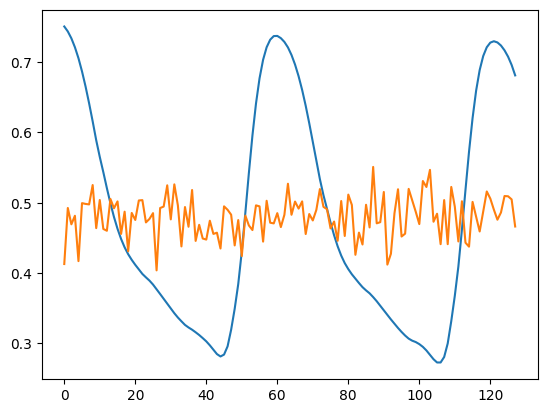

In [14]:
plt.plot(trg_y.detach().cpu().numpy()[4, :, 0])
plt.plot(output.detach().cpu().numpy()[4, :, 0])